In [1]:
import requests
import httpx
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup


In [2]:
class Bolsa: #defino la clase bolsa
    async def __new__(cls, urlDiferencia=None, urlHistorico=None):
        self = super().__new__(cls)

        #defino los links donde busco los datos de las bolsas
        self.urlDiferencia = urlDiferencia or 'https://www.bolsamadrid.es/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000&punto=indice'
        self.urlHistorico = urlHistorico or 'https://www.bolsamadrid.es/esp/aspx/Empresas/InfHistorica.aspx?'
        #genero la tabla de diferencia
        self.__generateTablaDiferencia()
        #genero la tabla de valores historicos
        await self.__generateTablaHistorico()
        return self
    
    def __generateTablaDiferencia(self): #metodo que genera la tabla de diferencias
        r = requests.get(self.urlDiferencia).text
        soup = BeautifulSoup(r, 'lxml')
        tablaDiferencia = soup.findAll('table', id='ctl00_Contenido_tblAcciones')
        df = pd.read_html(str(tablaDiferencia))[0]
        df['% Dif.'] = df['% Dif.'].apply(lambda x: x/100)
        
        #guardo la tabla de diferencia
        self.tablaDiferencia = tablaDiferencia
        # guardo el dataframe de diferencia
        self.dfDiferencia = df

    def getTablaDiferencia(self): #método que devuelve el dataframe de diferencia
        return self.dfDiferencia
    
    def printGraficoDiferencia(self): #método que grafica la diferencia
        fig, ax = plt.subplots(figsize=(10, 10))
        fig.suptitle('Gráfico porcentaje', fontsize=16)
        self.dfDiferencia.plot(kind='bar', y='% Dif.', x='Nombre', ax=ax)

    def __getLinksFromTabla(self): #método que obtiene los links para acceder a cada accion en particular
        links = [td['href'].split('?')[1]
                for td in self.tablaDiferencia[0].find_all('a')]
        return links
    
    async def __generateTablaHistorico(self): #método que genera la tabla de valores historicos
        df = []
        head = ['Cierre', 'Referencia', 'Último', 'Máximo', 'Mínimo', 'Medio']
        
        async with httpx.AsyncClient() as client:
            for l in self.__getLinksFromTabla():
                data = await client.get(self.urlHistorico+l)
                soup = BeautifulSoup(data.text, 'lxml')
                tabla = soup.findAll('table', id='ctl00_Contenido_tblDatos')
                df.append(pd.read_html(str(tabla))[0])
                for h in head:
                    df[-1][h] = df[-1][h].apply(lambda x: x/1000)
            #guardo la tabla
            self.tablaHistorico = tabla
            #guardo el dataframe
            self.dfHistorico = df

    def printGraficoHistorico(self): #metodo que grafica el valor historico de las acciones
        fig, _ = plt.subplots(nrows=7, ncols=5, figsize=(30, 30))
        fig.suptitle('Gráficos de valor hasta la actualidad', fontsize=16)
        for i in range(len(self.dfHistorico)):
            axe = plt.subplot(7, 5, i+1)
            axe.set_title(self.dfDiferencia['Nombre'][i])
            self.dfHistorico[i].plot(kind='line', y='Cierre', x='Fecha', ax=axe)
        fig.tight_layout(pad=2.0)


In [3]:
bolsa_madrid = await Bolsa() #creo un objeto bolsa (tiene el await porque ejecuta metodos asincronos)
#asincronos tiene que ver con llamadas a páginas web, mientras espera la respuesta de la misma,
#no se queda esperando esa respuesta, sino que sigue ejecutando codigo hasta que esa respuesta llegue,
#luego la procesa.

In [4]:
bolsa_madrid.getTablaDiferencia() #obtengo la tabla de diferencias

,Nombre,Últ.,% Dif.,Máx.,Mín.,Volumen,Efectivo (miles €),Fecha,Hora
0,ACCIONA,1671000,1.64,1671000,1643000,74.165,"12.343,60",28/10/2021,Cierre
1,ACERINOX,119950,0.00,120150,119050,1.533.380,"18.355,00",28/10/2021,Cierre
2,ACS,226300,-0.31,227600,223500,2.099.583,"47.548,15",28/10/2021,Cierre
3,AENA,1430500,0.92,1430500,1394500,748.510,"105.709,57",28/10/2021,Cierre
4,ALMIRALL,128200,0.55,128600,126800,168.503,"2.158,48",28/10/2021,Cierre
5,AMADEUS,572000,0.18,577000,564400,596.033,"34.058,49",28/10/2021,Cierre
6,ARCELORMIT.,289500,-0.63,290550,286200,239.967,"6.917,65",28/10/2021,Cierre
7,B.SANTANDER,32805,0.60,33000,31980,63.954.609,"195.354,08",28/10/2021,Cierre
8,BA.SABADELL,6840,4.46,6874,6516,52.117.488,"34.726,46",28/10/2021,Cierre
9,BANKINTER,47670,1.25,47880,46480,2.400.048,"11.343,31",28/10/2021,Cierre


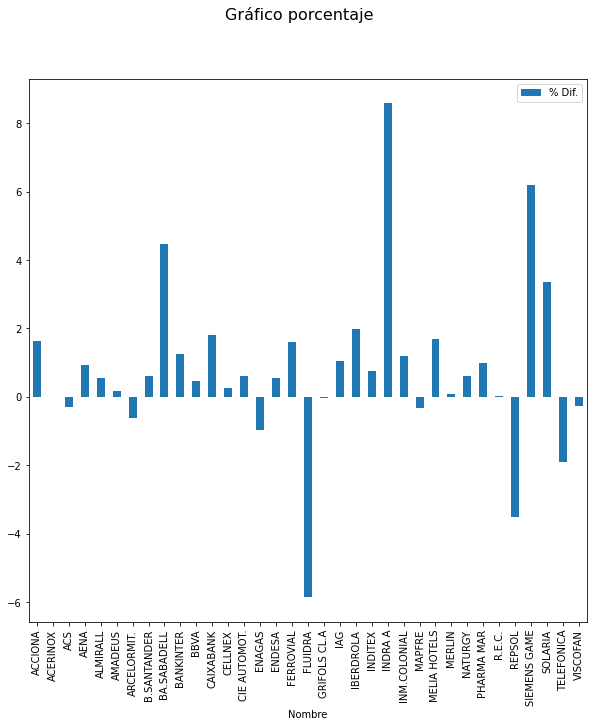

In [5]:
bolsa_madrid.printGraficoDiferencia() #grafico la diferencia

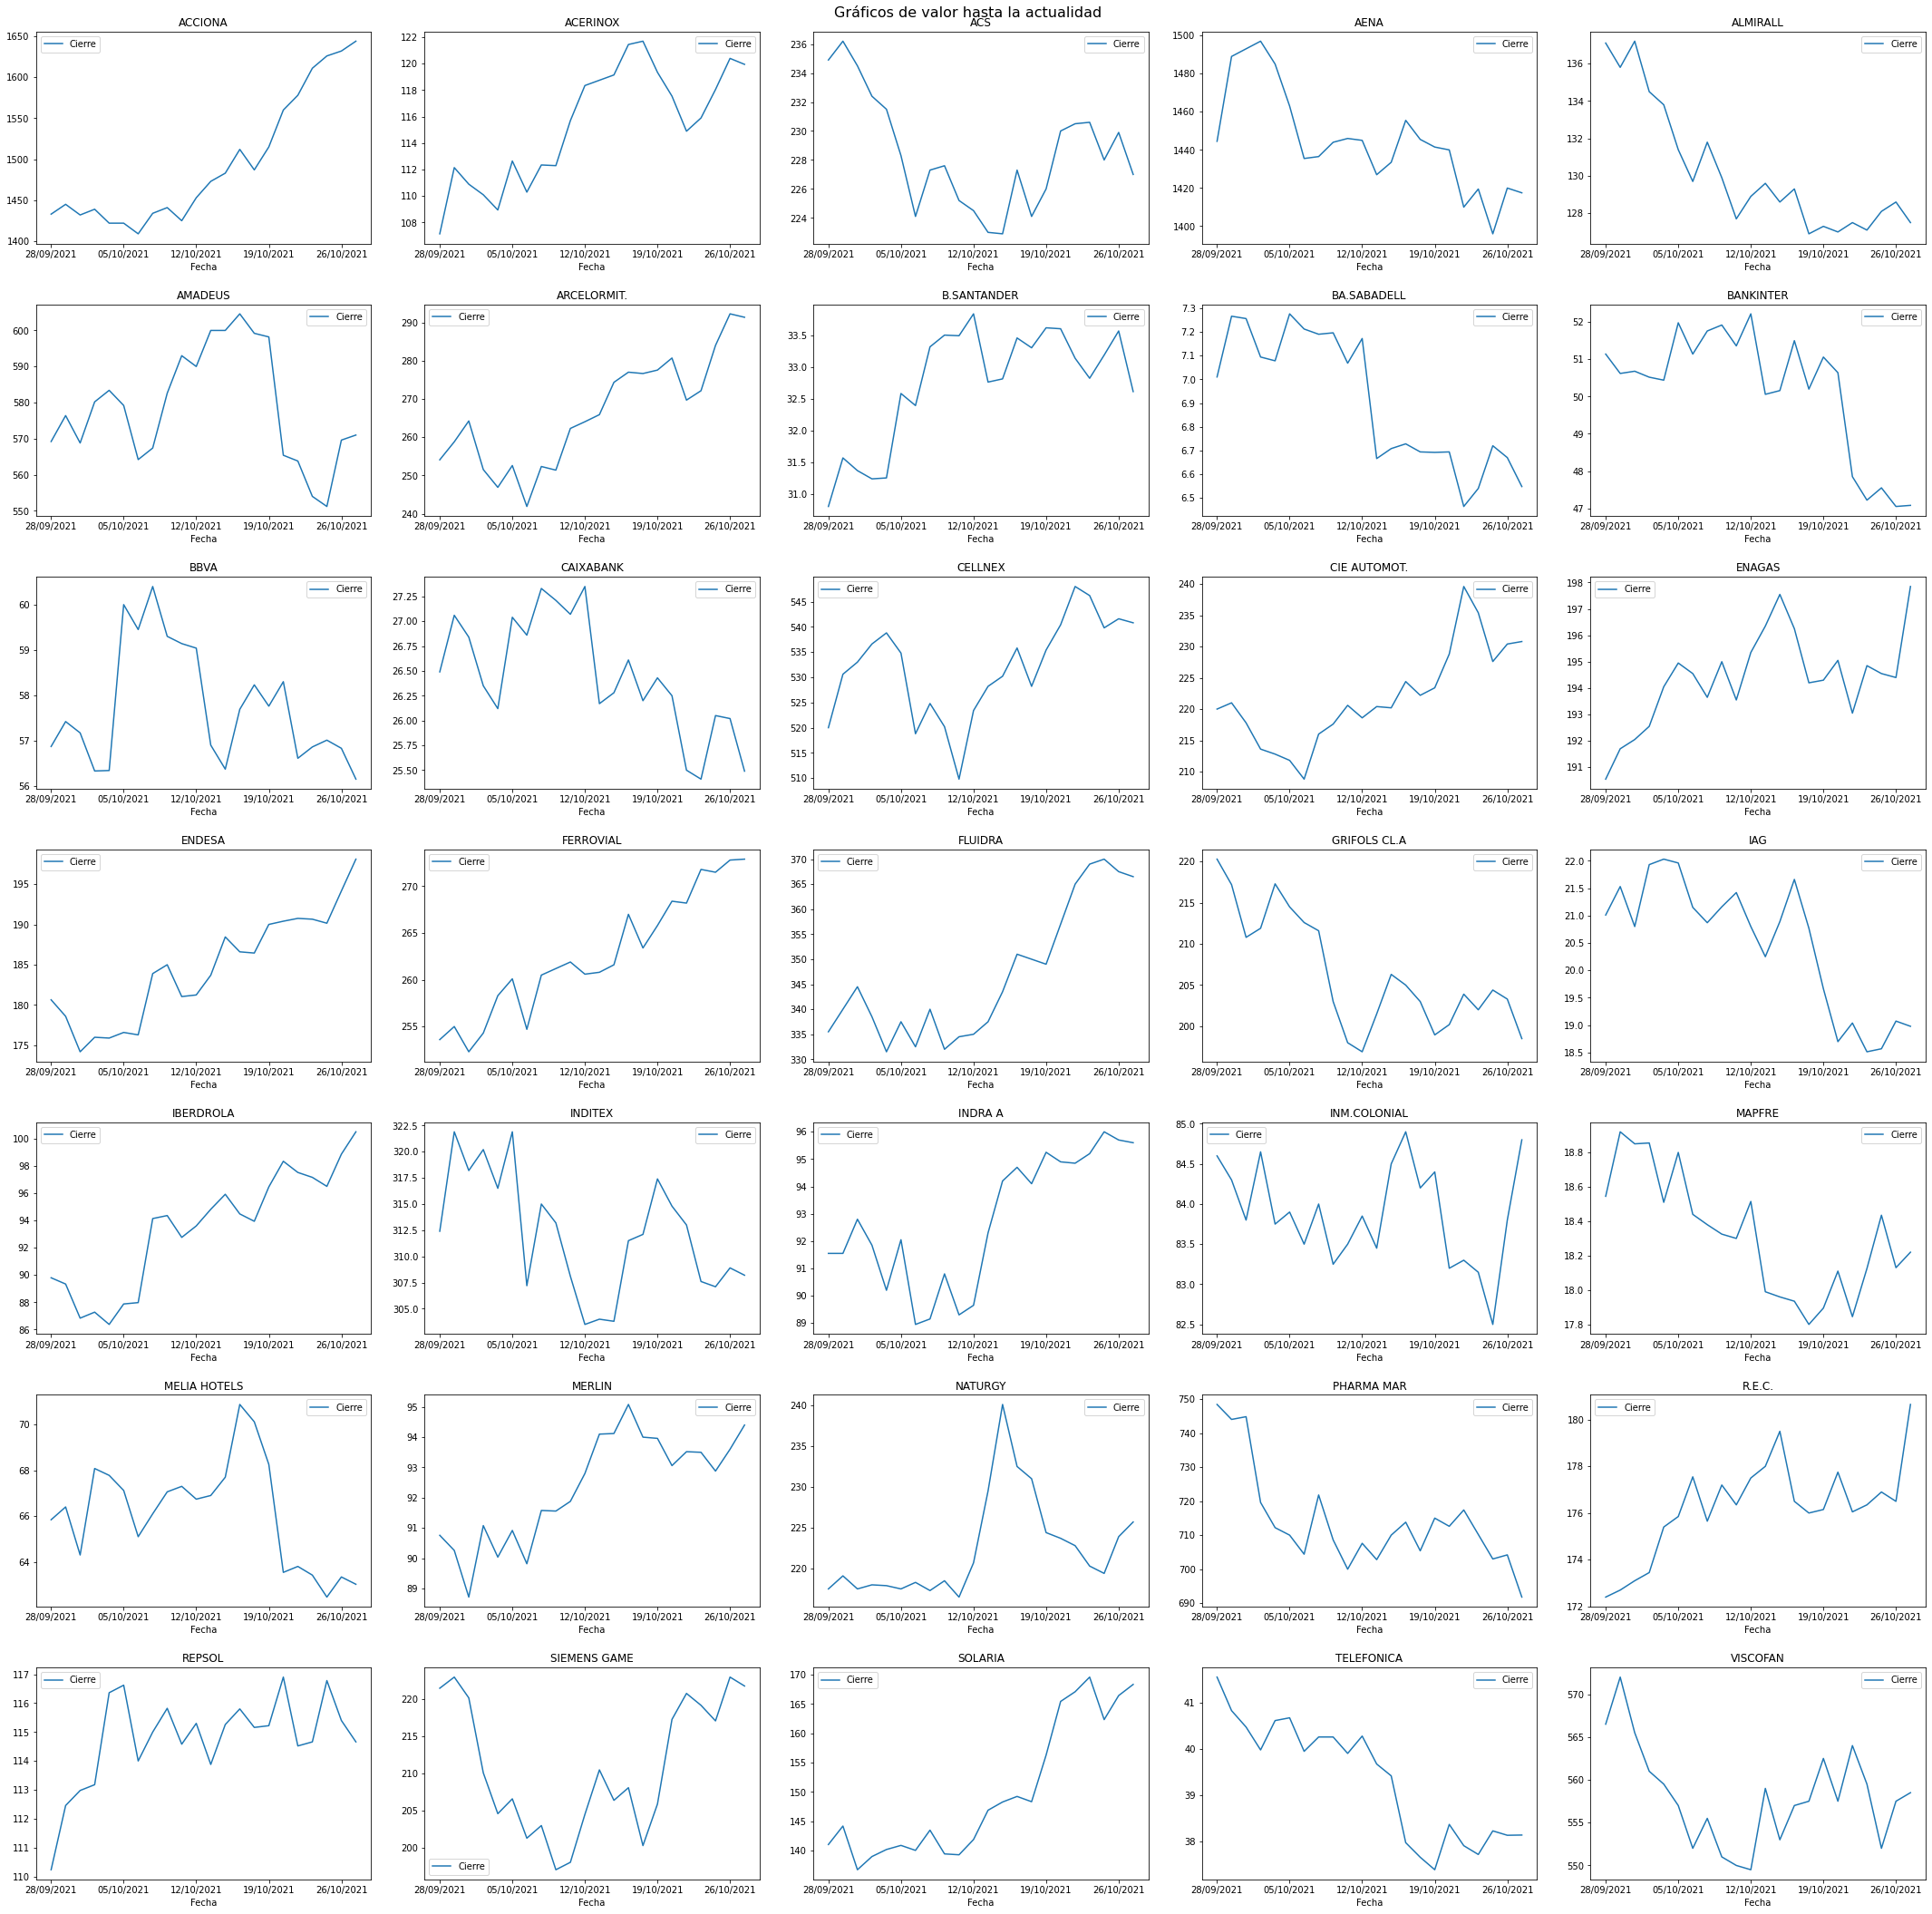

In [6]:
bolsa_madrid.printGraficoHistorico() #grafico los valores historicos de las acciones